## Text Similarity Feature

The goal here is to check the performance of openai and cohere embedding model on some specific datasets on 
textual similarity and to detect plagiarism.

### Reporting results
#### STSB dataset (1500 datasets. Very short sentences)
> Note: Time eval not that accurate as it includes time it takes for dataset to run. I made sure to restart kernel between runs.

__text-embedding-3-small__

time = 38secs (0.63mins); correlation = 0.88

__text-embedding-3-large__

time = 34secs (0.57mins); correlation = 8.88

#### MRPC dataset (408 datasets. somewhat short sentences as well)
>Note this eval does not include time required to load dataset

After eyeballing the MRPC dataset, it is a really tricky dataset because any model that really does well on the dataset would have to be good at making a really good distinction between paraphrased entry(in that text2 is a paraphrased text that stays on topic) and semantic entry(in that text2 is a semantic text that good number of words in texts but generally does not stay on topic).

##### text-embedding-3-small

Scaled similarity embeddings have length 408 same as dataset. hence each score represents an entry in the dataset.

time = 11.3 secs (0.19 minutes); 
mean-similarity (equivalent pair) = 0.93
mean-similarity (non-equivalent pair) = 0.87
separation between the two = 0.06

**classification metrics**
precision = 0.7319
recall = 0.9785
f1-Score = 0.8374

**ranking metrics**
ROC-AUC = 0.7711
PR-AUC = 0.8755

##### text-embedding-3-large

Scaled similarity embeddings have length 408 same as dataset. hence each score represents an entry in the dataset.

time = 14.85 seconds (0.25 minutes); 
mean-similarity (equivalent pair) = 0.93
mean-similarity (non-equivalent pair) = 0.87
separation between the two = 0.06

**classification metrics**
precision = 0.7549
recall = 0.9606
f1-Score = 0.8454

**ranking metrics**
ROC-AUC = 0.7816
PR-AUC = 0.8809

#### Clough-and-Stevenson plagiarism dataset

##### text-embedding-3-small
mean similarity score
no-plagiarism = 0.88
light-paraphrase = 0.95
heavy-paraphrase = 0.93
near-copy = 0.93

### Summary
- For STSB, openai embedding small and large achieved a correlation of `0.88` with ground-truth labels on STSB dataset with no clear winner.
- For MRPC, openai embedding small and large have about the same scores. So going forward. There is not much benefit testing on `text-embedding-3-large`.
- For 

## Evaluate OPENAI embed model on STSB dataset

In [ ]:
# @title Load STSB dataset

from datasets import load_dataset

# Load STSB validation set for a quick evaluation
dataset = load_dataset("sentence-transformers/stsb", split="validation")

# The validation set has 1500 pairs

# Get all pairs and true scores
sents1 = dataset["sentence1"]
sents2 = dataset["sentence2"]
scores = dataset["score"]  # Ground truth similarity scores (float: 0-1)

In [ ]:
# @title Evaluate openai model on STSB dataset on huggingface

# Evaluate openai embedding on STSB dataset on huggingface
# Url https://huggingface.co/datasets/sentence-transformers/stsb
from openai import OpenAI
import numpy as np
from scipy.stats import spearmanr
from dotenv import load_dotenv
import os
import time

# Start timing
start_time = time.time()

# Load environment variables from .env file
load_dotenv()

# Set your OpenAI API key from .env file
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file. Please create a .env file with OPENAI_API_KEY=your_key")

client = OpenAI(api_key=openai_api_key)

def get_openai_embedding(text, model="text-embedding-ada-002"):
    # Handles too-long texts by truncating
    if len(text) > 8191:
        text = text[:8191]
    response = client.embeddings.create(model=model, input=[text])
    return response.data[0].embedding

def batch_get_openai_embeddings(texts, model="text-embedding-ada-002", batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        response = client.embeddings.create(model=model, input=batch)
        batch_embeds = [item.embedding for item in response.data]
        embeddings.extend(batch_embeds)
    return embeddings



print("Fetching embeddings for sentence1...")
embeds1 = batch_get_openai_embeddings(sents1, model="text-embedding-3-large")
print("Fetching embeddings for sentence2...")
embeds2 = batch_get_openai_embeddings(sents2, model="text-embedding-3-large")

# Cosine similarity function
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Compute similarity scores
pred_similarities = [
    cosine_similarity(e1, e2) for e1, e2 in zip(embeds1, embeds2)
]
# Scale cosine similarity (-1..1) to (0..1) to match the normalized STSB scoring
pred_similarities_scaled = [(sim + 1) / 2 for sim in pred_similarities]

# Evaluate with Spearman correlation coefficient
spearman_corr, _ = spearmanr(pred_similarities_scaled, scores)
print(f"OpenAI embedding on STSB (validation): Spearman correlation = {spearman_corr:.4f}")

# End timing and print duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

Fetching embeddings for sentence1...
Fetching embeddings for sentence2...
OpenAI embedding on STSB (validation): Spearman correlation = 0.8775

Total execution time: 33.93 seconds (0.57 minutes)


## Evaluate OPENAI embed model on MRPC dataset

In [1]:
# @title Load MRPC dataset
# url https://huggingface.co/datasets/SetFit/mrpc
from datasets import load_dataset

# The validation set has 408 pairs
dataset = load_dataset("SetFit/mrpc", split="validation")

# There is no score here only binary label (`0` and `1`)
# 1 means equivalent(SIMILAR)
# 0 means non-equivalent(DISSIMILAR)
# The two texts are labeled text1 and text2
len(dataset)

Repo card metadata block was not found. Setting CardData to empty.


408

In [2]:
# @title Evaluate openai model on MRPC dataset
# url https://huggingface.co/datasets/SetFit/mrpc

from openai import OpenAI
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from dotenv import load_dotenv
import os
import time

# Start timing
start_time = time.time()

# Load environment variables from .env file
load_dotenv()

# Set your OpenAI API key from .env file
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file. Please create a .env file with OPENAI_API_KEY=your_key")

client = OpenAI(api_key=openai_api_key)

def batch_get_openai_embeddings(texts, model="text-embedding-ada-002", batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        response = client.embeddings.create(model=model, input=batch)
        batch_embeds = [item.embedding for item in response.data]
        embeddings.extend(batch_embeds)
    return embeddings

# Get text pairs and labels
text1 = dataset["text1"]
text2 = dataset["text2"]
labels = dataset["label"]  # Binary labels: 1 = similar, 0 = dissimilar

print("Fetching embeddings for text1...")
embeds1 = batch_get_openai_embeddings(text1, model="text-embedding-3-large")
print("Fetching embeddings for text2...")
embeds2 = batch_get_openai_embeddings(text2, model="text-embedding-3-large")

# Cosine similarity function
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Compute similarity scores (range: -1 to 1)
pred_similarities = np.array([
    cosine_similarity(e1, e2) for e1, e2 in zip(embeds1, embeds2)
])

# Scale cosine similarity (-1..1) to (0..1) for easier threshold interpretation
pred_similarities_scaled = (pred_similarities + 1) / 2

# Find optimal threshold that maximizes F1-score
best_threshold = 0.5
best_f1 = 0
thresholds = np.arange(0, 1.01, 0.01)

for threshold in thresholds:
    pred_labels = (pred_similarities_scaled >= threshold).astype(int)
    f1 = f1_score(labels, pred_labels)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Predictions using optimal threshold
pred_labels = (pred_similarities_scaled >= best_threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(labels, pred_labels)
precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels)

# Calculate ROC-AUC and PR-AUC (using scaled similarities as probabilities)
roc_auc = roc_auc_score(labels, pred_similarities_scaled)
pr_auc = average_precision_score(labels, pred_similarities_scaled)

# Calculate mean similarity scores for equivalent and non-equivalent pairs
labels_array = np.array(labels)
mean_sim_equivalent = np.mean(pred_similarities_scaled[labels_array == 1])
mean_sim_non_equivalent = np.mean(pred_similarities_scaled[labels_array == 0])
separation = mean_sim_equivalent - mean_sim_non_equivalent

print(f"\n{'='*60}")
print(f"OpenAI embedding on MRPC (validation) - Binary Classification")
print(f"{'='*60}")
print(f"Optimal threshold: {best_threshold:.3f}")
print(f"\nLength of scaled pred similarities: {len(pred_similarities_scaled)}")
print(f"\nSimilarity Score Statistics:")
print(f"  Mean similarity (Equivalent pairs):     {mean_sim_equivalent:.4f}")
print(f"  Mean similarity (Non-equivalent pairs): {mean_sim_non_equivalent:.4f}")
print(f"  Separation (Difference):                {separation:.4f}")
print(f"\nClassification Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"\nRanking Metrics:")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")
print(f"{'='*60}")

# End timing and print duration
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")


Fetching embeddings for text1...
Fetching embeddings for text2...

OpenAI embedding on MRPC (validation) - Binary Classification
Optimal threshold: 0.840

Length of scaled pred similarities: 408

Similarity Score Statistics:
  Mean similarity (Equivalent pairs):     0.9302
  Mean similarity (Non-equivalent pairs): 0.8718
  Separation (Difference):                0.0584

Classification Metrics:
  Accuracy:  0.7598
  Precision: 0.7549
  Recall:    0.9606
  F1-Score:  0.8454

Ranking Metrics:
  ROC-AUC:   0.7816
  PR-AUC:    0.8809

Total execution time: 14.85 seconds (0.25 minutes)


## Evaluate OPENAI embed model on Clough-Stevenson plagiarism dataset


In [2]:
# @title Load plagiarism dataset
import json
from pathlib import Path

plagiarism_path = Path("plagiarism_dataset.jsonl")
if not plagiarism_path.exists():
    raise FileNotFoundError(f"Could not find {plagiarism_path} relative to the notebook directory")

with plagiarism_path.open("r", encoding="utf-8") as fp:
    plagiarism_records = [json.loads(line) for line in fp if line.strip()]

print(f"Loaded {len(plagiarism_records)} entries from {plagiarism_path}")
available_categories = sorted({rec["paraphrase_category"] for rec in plagiarism_records})
print(f"Available categories: {available_categories}")


Loaded 95 entries from plagiarism_dataset.jsonl
Available categories: ['cut', 'heavy', 'light', 'non']


In [3]:
# @title Compute embeddings and metrics for plagiarism dataset
import os
from collections import defaultdict

import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file. Please create a .env file with OPENAI_API_KEY=your_key")

client = OpenAI(api_key=openai_api_key)
EMBED_MODEL = "text-embedding-3-small"
MAX_CHARS = 8000


def _prepare_text(text: str, max_chars: int = MAX_CHARS) -> str:
    text = text.strip()
    return text[:max_chars] if len(text) > max_chars else text


def embed_texts(texts, model: str = EMBED_MODEL, batch_size: int = 32):
    """Return embeddings for each text while caching duplicates."""
    unique_texts = list(dict.fromkeys(texts))
    cache = {}
    for start in range(0, len(unique_texts), batch_size):
        batch_original = unique_texts[start:start + batch_size]
        batch_inputs = [_prepare_text(text) for text in batch_original]
        response = client.embeddings.create(model=model, input=batch_inputs)
        for original_text, embedding in zip(batch_original, response.data):
            cache[original_text] = embedding.embedding
    return [cache[text] for text in texts]


def cosine_similarity(vec_a, vec_b):
    a = np.array(vec_a)
    b = np.array(vec_b)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


original_texts = [record["original_task_text"] for record in plagiarism_records]
paraphrase_texts = [record["paraphrase_text"] for record in plagiarism_records]
categories = [record["paraphrase_category"] for record in plagiarism_records]

print("Embedding original passages...")
orig_embeddings = embed_texts(original_texts)
print("Embedding paraphrases...")
para_embeddings = embed_texts(paraphrase_texts)

raw_similarities = np.array([cosine_similarity(o, p) for o, p in zip(orig_embeddings, para_embeddings)])
scaled_similarities = (raw_similarities + 1) / 2  # map from (-1, 1) to (0, 1)

for record, raw_sim, scaled_sim in zip(plagiarism_records, raw_similarities, scaled_similarities):
    record["raw_similarity"] = raw_sim
    record["scaled_similarity"] = scaled_sim

category_order = ["non", "light", "heavy", "cut"]
category_scores = defaultdict(list)
for record in plagiarism_records:
    category_scores[record["paraphrase_category"]].append(record["scaled_similarity"])

summary_rows = []
reference_mean = None
for category in category_order:
    scores = np.array(category_scores.get(category, []))
    if len(scores) == 0:
        continue
    mean_score = scores.mean()
    if category == "non":
        reference_mean = mean_score
    summary_rows.append({
        "category": category,
        "count": len(scores),
        "mean": mean_score,
        "median": float(np.median(scores)),
        "std": float(scores.std(ddof=0)),
        "min": float(scores.min()),
        "max": float(scores.max()),
    })

if reference_mean is not None:
    for row in summary_rows:
        row["delta_vs_non"] = row["mean"] - reference_mean

print("\nCategory-level similarity summary (scaled cosine in [0, 1]):")
for row in summary_rows:
    delta = row.get("delta_vs_non", 0.0)
    delta_str = f"{delta:+.4f}" if row["category"] != "non" else "n/a"
    print(
        f"- {row['category']:>5} | n={row['count']:>2} | mean={row['mean']:.4f} | "
        f"median={row['median']:.4f} | std={row['std']:.4f} | min={row['min']:.4f} | "
        f"max={row['max']:.4f} | Δ vs non = {delta_str}"
    )

severity_map = {"non": 0, "light": 1, "heavy": 2, "cut": 3}
severity_scores = np.array([severity_map[cat] for cat in categories])
spearman_corr, spearman_p = spearmanr(severity_scores, scaled_similarities)
print(
    f"\nSpearman correlation between similarity score and plagiarism severity: "
    f"{spearman_corr:.4f} (p={spearman_p:.4f})"
)

binary_labels = np.array([1 if cat != "non" else 0 for cat in categories])
roc_auc = roc_auc_score(binary_labels, scaled_similarities)
print(f"Binary detection ROC-AUC (non vs plagiarized): {roc_auc:.4f}")

best_metrics = None
for threshold in np.arange(0.0, 1.01, 0.01):
    preds = (scaled_similarities >= threshold).astype(int)
    acc = accuracy_score(binary_labels, preds)
    tp = int(((preds == 1) & (binary_labels == 1)).sum())
    fp = int(((preds == 1) & (binary_labels == 0)).sum())
    fn = int(((preds == 0) & (binary_labels == 1)).sum())
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    if not best_metrics or f1 > best_metrics["f1"]:
        best_metrics = {
            "threshold": threshold,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
        }

if best_metrics is None:
    raise RuntimeError("Unable to compute threshold-based metrics")

print(
    "Best plagiarism threshold (maximize F1): "
    f"{best_metrics['threshold']:.2f} -> accuracy={best_metrics['accuracy']:.4f}, "
    f"precision={best_metrics['precision']:.4f}, recall={best_metrics['recall']:.4f}, "
    f"F1={best_metrics['f1']:.4f}"
)

Embedding original passages...
Embedding paraphrases...

Category-level similarity summary (scaled cosine in [0, 1]):
-   non | n=38 | mean=0.8777 | median=0.8862 | std=0.0337 | min=0.7951 | max=0.9260 | Δ vs non = n/a
- light | n=19 | mean=0.9505 | median=0.9530 | std=0.0262 | min=0.8979 | max=0.9909 | Δ vs non = +0.0727
- heavy | n=19 | mean=0.9411 | median=0.9429 | std=0.0211 | min=0.8885 | max=0.9881 | Δ vs non = +0.0633
-   cut | n=19 | mean=0.9323 | median=0.9421 | std=0.0675 | min=0.6725 | max=0.9956 | Δ vs non = +0.0546

Spearman correlation between similarity score and plagiarism severity: 0.6376 (p=0.0000)
Binary detection ROC-AUC (non vs plagiarized): 0.9428
Best plagiarism threshold (maximize F1): 0.91 -> accuracy=0.8842, precision=0.9107, recall=0.8947, F1=0.9027


The metrics above capture:

- **Mean/median similarity per category** (non, light, heavy, cut) along with spread and min/max values, plus the delta relative to the "non" baseline.
- **Spearman correlation** between the ordinal plagiarism severity labels (`non < light < heavy < cut`) and the scaled cosine similarity, which shows how well the embedding-based similarity tracks the ground-truth ordering.
- **Binary plagiarism detection quality** by collapsing the task into `non` vs `plagiarized` (others), reported via ROC-AUC.
- **Best-performing similarity threshold** (sweeping 0.00–1.00) that maximizes F1, together with accuracy/precision/recall at that operating point.

Re-running the cells will refresh the summary for any updated embeddings, models, or dataset variants.


#### Similarity score distributions by paraphrase category

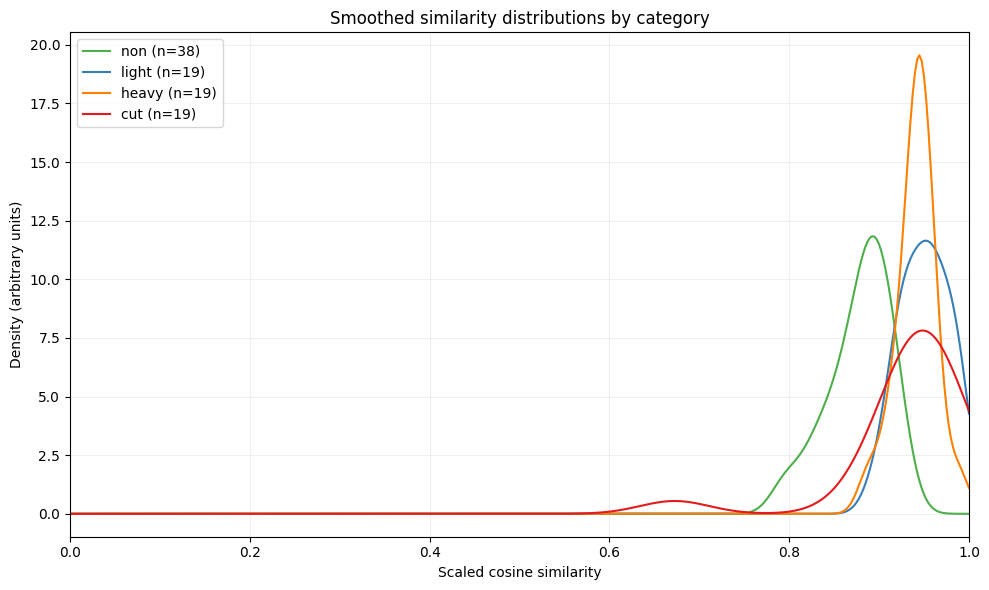

In [4]:
# @title Plot smoothed similarity histograms for each category
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_grid = np.linspace(0, 1, 400)
category_colors = {
    "non": "#4daf4a",
    "light": "#377eb8",
    "heavy": "#ff7f00",
    "cut": "#e41a1c",
}

plt.figure(figsize=(10, 6))
for category in category_order:
    scores = np.array(category_scores.get(category, []))
    if len(scores) == 0:
        continue
    # KDE needs at least two data points with non-zero variance
    if len(scores) >= 2 and scores.std() > 0:
        kde = gaussian_kde(scores)
        density = kde(x_grid)
    else:
        # Fallback to a very narrow normal centered on the single value
        bandwidth = 0.01
        density = np.exp(-0.5 * ((x_grid - scores.mean()) / bandwidth) ** 2)
        density /= density.max()
    plt.plot(x_grid, density, label=f"{category} (n={len(scores)})", color=category_colors.get(category))

plt.title("Smoothed similarity distributions by category")
plt.xlabel("Scaled cosine similarity")
plt.ylabel("Density (arbitrary units)")
plt.xlim(0, 1)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()